# <span style="color:#84b6f4;">Cálculo de métricas en vídeo</span>

### <span style="color:#77dd77;">Extracción de frames</span>

En este ejemplo, trataremos de calcular el tiempo en pantalla y las emociones transmitidas por Will Smith en el tráiler de "Bad Boys: Ride or Die". Comenzamos importando los modelos:

In [4]:
from joblib import load

actor_model = load('resources/models/will_smith_detection.joblib')
happy_model = load('resources/models/happy_detection.joblib')

Extraemos una muestra de los fotogramas del tráiler y los almacenamos en un directorio:

In [5]:
import cv2
import os

video_path =  os.getcwd() + '/resources/trailers/BAD_BOYS_RIDE_OR_DIE.mp4'
frames_dir =  os.getcwd() + '/resources/filmFrames/badBoysRideOrDie'
if not os.path.exists(frames_dir):
    os.makedirs(frames_dir)

# Cargar el vídeo
vidcap = cv2.VideoCapture(video_path)

# Obtener la tasa de fotogramas (FPS) del vídeo
fps = vidcap.get(cv2.CAP_PROP_FPS)

success, image = vidcap.read()
count = 0
frame_index = 0

# Determinar cuántos frames se extraerán (para obtener una muestra)
skip_frames = int(fps / 2) if fps > 2 else 1

while success:
    # Guardar el fotograma actual en el directorio frames_dir
    if count % skip_frames == 0:
        cv2.imwrite(os.path.join(frames_dir, f"frame{count:04d}.jpg"), image)
        print(f'Procesado fotograma: {count}')
        frame_index += 1
        
    success, image = vidcap.read()
    count += 1

print(f'Fotogramas extraídos: {frame_index}')

Procesado fotograma: 0
Procesado fotograma: 11
Procesado fotograma: 22
Procesado fotograma: 33
Procesado fotograma: 44
Procesado fotograma: 55
Procesado fotograma: 66
Procesado fotograma: 77
Procesado fotograma: 88
Procesado fotograma: 99
Procesado fotograma: 110
Procesado fotograma: 121
Procesado fotograma: 132
Procesado fotograma: 143
Procesado fotograma: 154
Procesado fotograma: 165
Procesado fotograma: 176
Procesado fotograma: 187
Procesado fotograma: 198
Procesado fotograma: 209
Procesado fotograma: 220
Procesado fotograma: 231
Procesado fotograma: 242
Procesado fotograma: 253
Procesado fotograma: 264
Procesado fotograma: 275
Procesado fotograma: 286
Procesado fotograma: 297
Procesado fotograma: 308
Procesado fotograma: 319
Procesado fotograma: 330
Procesado fotograma: 341
Procesado fotograma: 352
Procesado fotograma: 363
Procesado fotograma: 374
Procesado fotograma: 385
Procesado fotograma: 396
Procesado fotograma: 407
Procesado fotograma: 418
Procesado fotograma: 429
Procesado f

### <span style="color:#77dd77;">Predicción</span>

Teniendo en cuenta que Will Smith aparece alrededor de 66 segundos en el tráiler, predecimos en cada frame en el que YOLO detecte la presencia de algún rostro si Will Smith aparece o no, además de si los frames en los que aparece transmiten o no felicidad, estimando el tiempo de aparición y las emociones que el actor transmite:

1/1 [==============================] - 0s 122ms/step


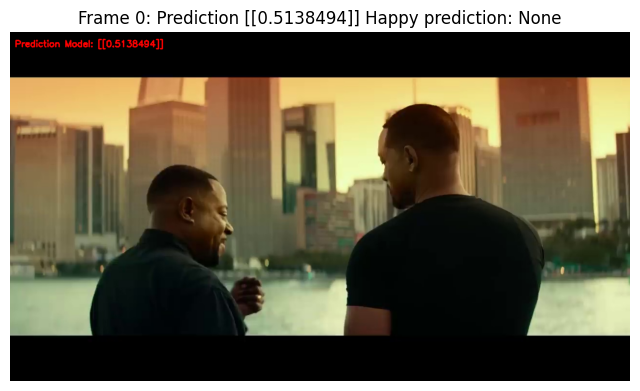

1/1 [==============================] - 0s 17ms/step


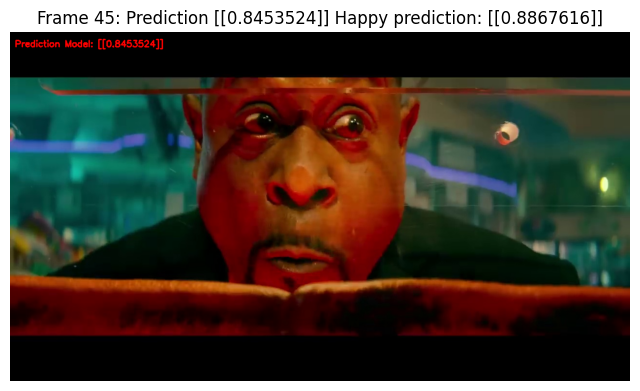

1/1 [==============================] - 0s 20ms/step


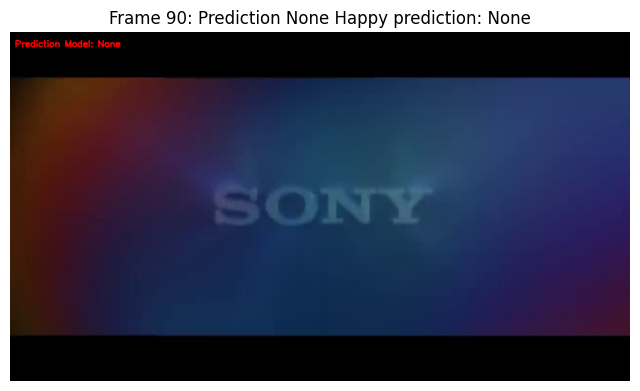

1/1 [==============================] - 0s 19ms/step


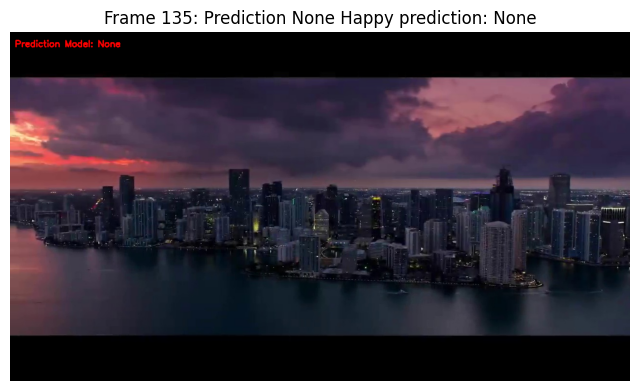

1/1 [==============================] - 0s 19ms/step


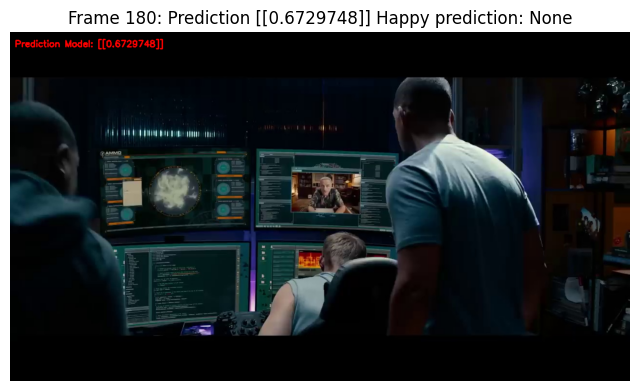

1/1 [==============================] - 0s 19ms/step


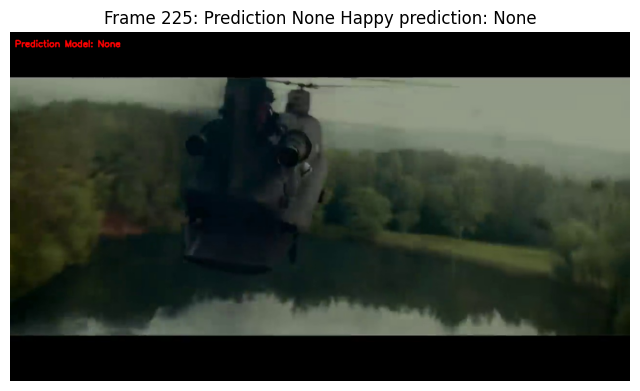

1/1 [==============================] - 0s 20ms/step


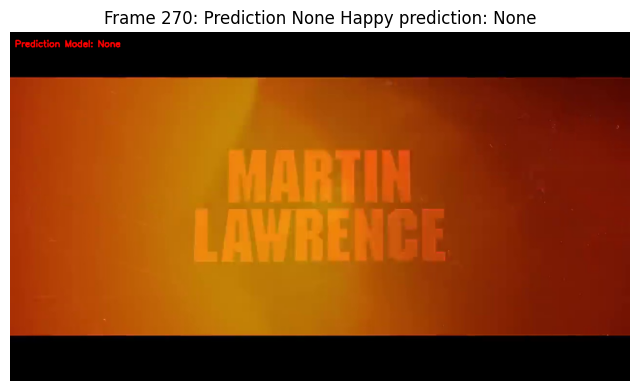

1/1 [==============================] - 0s 23ms/step


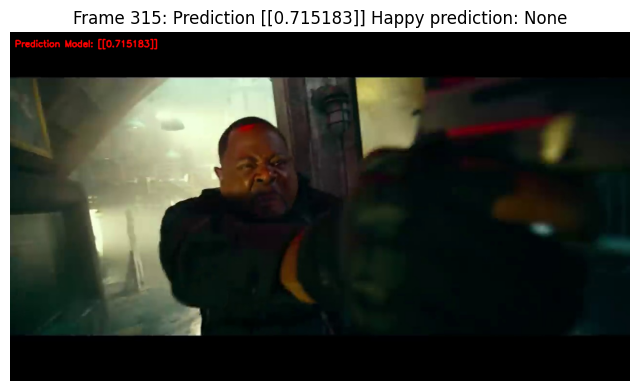

1/1 [==============================] - 0s 17ms/step


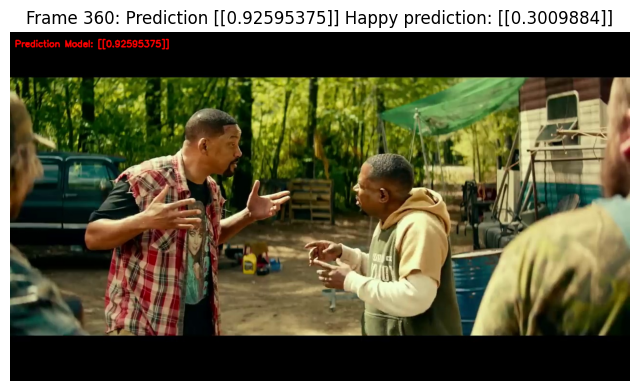

1/1 [==============================] - 0s 19ms/step
El actor apareció durante 65.5 segundos.
Transmitió felicidad durante 7.5 segundos.


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Configuración del modelo YOLO
def load_yolo_model(cfg_path, weights_path, names_path):
    net = cv2.dnn.readNet(weights_path, cfg_path)
    with open(names_path, 'r') as f:
        classes = f.read().strip().split('\n')
    return net, classes

# Detección de humanos en un fotograma
def detect_human(frame, net, output_layers, threshold=0.8):
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > threshold and class_id == 0:  # Clase 0 es 'person'
                return True, detection
    return False, None

# Cargar el modelo YOLO
cfg_path = os.path.join(os.getcwd(), 'resources/yolov3.cfg')
weights_path = os.path.join(os.getcwd(), 'resources/yolov3.weights')
names_path = os.path.join(os.getcwd(), 'resources/coco.names')

net, classes = load_yolo_model(cfg_path, weights_path, names_path)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Enumerar todos los fotogramas extraídos
frames_dir = os.getcwd() + '/resources/filmFrames/badBoysRideOrDie'
frame_files = [f for f in os.listdir(frames_dir) if os.path.isfile(os.path.join(frames_dir, f))]

human_threshold = 0.8
actor_threshold = 0.75
happy_threshold = 0.5
actor_frame_count = 0
happy_frame_count = 0
show_frame_interval = 45

for index, frame_file in enumerate(frame_files): # Para cada frame
    frame_path = os.path.join(frames_dir, frame_file)
    image = cv2.imread(frame_path)

    detected, detection = detect_human(image, net, output_layers, human_threshold)
    actor_prediction = None
    happy_prediction = None

    if detected: # Si aparece un ser humano
        processed_image = cv2.resize(image, (100, 100))
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
        processed_image = processed_image.reshape(-1, 100, 100, 1) / 255.0  # Normalizar

        # Hacer la predicción usando el modelo de detección de actores
        actor_prediction = actor_model.predict(processed_image)

        processed_image = cv2.resize(image, (48, 48))
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2GRAY)
        processed_image = processed_image.reshape(-1, 48, 48, 1) / 255.0

        if actor_prediction > actor_threshold:
            actor_frame_count += 1
            happy_prediction = happy_model.predict(processed_image)
            if happy_prediction > happy_threshold:
                happy_frame_count += 1

    # Mostrar cada 35 fotogramas
    if index % show_frame_interval == 0:
        display_frame = image.copy()
        cv2.putText(display_frame, f'Prediction Model: {actor_prediction}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        # Mostrar el fotograma con Matplotlib
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
        plt.title(f'Frame {index}: Prediction {actor_prediction} Happy prediction: {happy_prediction}')
        plt.axis('off')
        plt.show()

appearance_time = actor_frame_count / 2
happy_time = happy_frame_count / 2
print(f"El actor apareció durante {appearance_time} segundos.")
print(f"Transmitió felicidad durante {happy_time} segundos.")